<a href="https://colab.research.google.com/github/EddieMcT/Map_Generator/blob/main/Parallelised_world_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test of notebook for Google Collab

# Welcome to the Parallelised Worlds landscape generator

To use this notebook, simply shift+enter through each of the cells below. Either CPU or GPU runtimes may be used, and cuda accelration will be enabled automatically if available.

To use the interactive mode, run the complete notebook then use the GUI provided in the last cell

## Step 1: Setup

If you're running this locally, make sure that you've downloaded the rest of the repository from https://github.com/EddieMcT/Map_Generator (or extracted the .zip that was provided with this notebook), then you can skip the first cell.  
If you're running this on Google Collab, run the first cell below to load the latest version of the generator.

In [1]:
# Setup steps, specific to collab and already tested, reaches an equivalent state to the local notebook
!git clone https://github.com/EddieMcT/Map_Generator.git
%cd Map_Generator/

# !pip install ipywidgets
from google.colab import output
output.enable_custom_widget_manager()


Cloning into 'Map_Generator'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (154/154), done.
remote: Total 241 (delta 91), reused 134 (delta 35), pack-reused 45 (from 1)
Receiving objects: 100% (241/241), 247.24 MiB | 25.43 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/Map_Generator


In [2]:

import dataclasses
import matplotlib.pyplot as plt

plt.switch_backend("inline")

from main import main, load_params, run, Params
import map_generator.backend_switch as np
from map_generator.globals import REPO_ROOT
from map_generator.parameters import to_yaml
from map_generator.imaging_functions import flatten_negative, normalize, to_numpy
import map_generator.parameters
import plotly.graph_objs as go
import ipywidgets as widgets
from IPython.display import display, clear_output
from datetime import datetime
# import plotly
# plotly.io.renderers.default = "colab"

cupy imported. Checking for CUDA availability...
cupy import failed. Disabling GPU acceleration.
Using numpy for CPU processing.


## Step 2: Running with default parameters

First we will Load in the parameters for the generator and create a test render.  
If you've used this generator previously and have .yaml files you want to keep working with, you can move these to the /params/default folder now in order to start with these.

In [3]:

input_folder = REPO_ROOT / "params/default"
output_folder = REPO_ROOT / "output"
default_params = load_params(input_folder=input_folder, output_folder=output_folder)

Now we can generate the map.  
This should typically take a few seconds for the default parameters (resolution of 256, tiling of 8).  
For now, autosaving is turned off, so we will need to plot the image separately to see it.

Note that as well as Z, the blended height of our terrain, we get separate outputs for the base height, mountains, and rivers.  
A separate output is planned for custom blending of the rivers, but this is not yet used (therefore an underscore is used as the placeholder).

2218.75 meters per pixel at zoom 3.5
Tiling the map into 2 parts for memory management


Generating map sections: 100%|██████████| 2/2 [00:03<00:00,  1.72s/it]

Time taken to generate the map: 3.47 seconds
-0.44712456565069675
1.8278620826655338


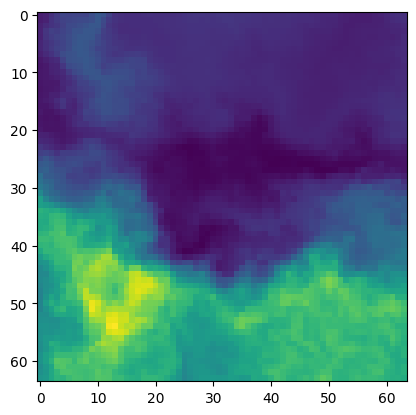

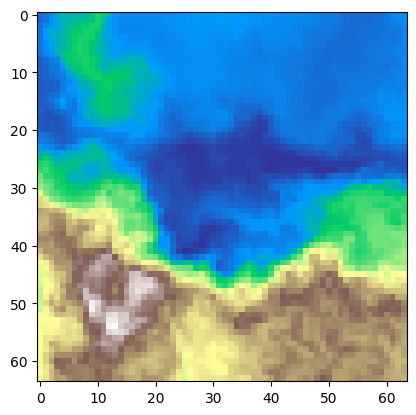

In [4]:
base, mountains, Z, river_z, _ = run(params=default_params, autosave=False)
plt.imshow(Z, cmap='terrain')

 To examine the default world and image parameters that were used, we can convert these to dictionaries and print the items.

In [5]:
world_params = default_params.root_params.world
dict_params = dataclasses.asdict(world_params)
for k, v in dict_params.items():
    print(f"\"{k}\": {v} ,")

"world_size": 500 ,
"mountain_heights": 0.1 ,
"river_scale": 300.0 ,
"centroids": [[0.0, 1.0], [1.0, 0.0], [1.0, 1.0], [0.0, 0.0], [0.0, 0.5], [0.5, 0.0], [0.5, 1.0], [1.0, 0.5], [0.49, 0.63], [0.01, 0.35], [0.49, 0.49], [0.67, 0.01], [0.02, 0.81], [0.64, 0.6], [0.79, 0.82], [0.84, 0.91], [0.91, 0.03], [0.35, 0.995], [0.1, 0.42], [0.82, 0.17], [0.23, 0.55], [0.4, 0.65], [0.36, 0.55]] ,
"heights_tectonic_plates": [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 0.7771805304378225, 0.1936184282179353, 0.8245285649776841, 0.522499433942889, -0.6177476518354117, 0.24609790071531346, 0.16947651525854746, -0.3423403085067549, -0.39072024023382135, -0.6098492643145285, 0.1425332372922219, 0.06516892726362311, 0.3399975845099701, 0.3113789115952983, -0.26060260627611564] ,
"slopes_x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.20748919763396267, 0.732186314455628, 0.018543074945194842, 0.0001528375228254992, -0.3943891529815844, -0.13320414735396915, -0.005081301591913844, 0.00047372590463434

In [6]:
imaging_params = default_params.root_params.imaging
dict_params = dataclasses.asdict(imaging_params)
for k, v in dict_params.items():
    print(f"\"{k}\": {v} ,")

"offset_x": -50.0 ,
"offset_y": -140.0 ,
"zoom": 3.5 ,
"resolution": 64 ,
"tiling": 2 ,


## Step 3, Editing parameters  

There are many parameters to edit, if you've already changed the default parameters that were loaded (e.g. by copying your existing project into params/default), then you should copy the contents of these here before fine-tuning them.


### World Parameters
World parameters describe the particular fictional world you will be generating.   
If these are kept constant, then by changing the imaging parameters in a later step you can generate multiple maps of the same consistent world.  
I've written this guide with a square world in mind, which translates well to a game map, but a circular arrangement or any other shape is possible too if distances are kept proportional.
____________________________________________________________________________
**World size** is the approximate distance (in km) from one size of this world to the other.   
* Maps can extend beyond this, but usually anything interesting is expected to be found within that area.

**Mountain heights** and **river scale** are the relative contribution of two methods of creating mountains.   
* Though more accurate for creating realistic maps, river noise is slow to calculate, so it can be useful to set this to 0 while drafting out other aspects of a world, and then introduce it later.  
* River_scale is in metres, and mountain_heights in km, so a default value of 1 and 1000 should give consistent values for both if you plan to manually blend these layers.  
* If you're using the automatically blended Z value, you should choose values that add together to approximately 1km or 1000m.

**Centroids** are pairs of locations (x,y) of the various plates/continents that make up your world.  
* These are relative to the world scale, so a location of 0,0 is one corner while 1,1 is diagonally opposite.  
* If your world has (like most do) a selection of landmasses surrounded by water, it's best to start with an outline of plates to enforce this before adding more organic features in the middle.  

**Heights** are the corresponding (average) height values of these plates.
* These range from -1 (deep oceanic) to 1 (high plateaus).  

**Slopes_x** and **slopes_y** are the slight variation in height across x and y coordinates for the height of a plate.   
* A slope of 1 means the plate would increase in height by 1km across the width of the entire world.  
* For boundary plates a slope of 0 is recommended.  
* Default values use gaussian noise so that the values are approximately found in a circle around 0.

**River density** is the number of major rivers one would expect to cross when walking in a straight line across the world.  
* This is only relevant for river_scale, so if that is 0 then this value is unused.  
* This is tested for values between 5 and 20.
* Because each river has multiple tiers of smaller branches and streams, higher values rapidly become crowded.

In [7]:
edited_world_params = {
    "world_size": 200 ,
    "mountain_heights": 1.0 ,
    "river_scale": 0.0 ,
    "centroids": [[0.0, 1.0], [1.0, 0.0], [1.0, 1.0], [0.0, 0.0], [0.0, 0.5], [0.5, 0.0], [0.5, 1.0], [1.0, 0.5],
                [0.49, 0.63], [0.01, 0.35], [0.49, 0.49], [0.67, 0.01], [0.02, 0.81], [0.64, 0.6], [0.79, 0.82],
                ] ,
    "heights_tectonic_plates": [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0,
                                0.7771805304378225, 0.1936184282179353, 0.8245285649776841, 0.522499433942889, -0.6177476518354117,
                                0.24609790071531346, 0.16947651525854746, ] ,
    "slopes_x": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                -0.20748919763396267, 0.732186314455628, 0.018543074945194842, 0.0001528375228254992, -0.3943891529815844,
                -0.13320414735396915, -0.005081301591913844,] ,
    "slopes_y": [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                -0.9520353967477023, 0.11799209623637652, 0.027651494252652134, -0.0001959657478424483, 0.20561991253689496,
                0.20761803957087918, 0.0020861120812645426, ] ,
    "river_density": 6 ,
    }

edited_world_params = map_generator.parameters.WorldParams.from_dict(edited_world_params)

## Imaging parameters

These describe the particular sample of the world you want to visualise.  
If these are changed while world parameters are constant, then you will create multiple maps of a consistent world.
________________________________________
**offset_x**, **offset_y** are the position from the world's centre (in kilometers).
* For example, a value of plus or minus half the world size will result in an image centred on the world's corners.
* Changing this by 1 will pan the image by 1km in the corresponding direction.

**Zoom** is relative to world size, such that a value of 1, with offsets of 0, will include everything from one corner of the world to the other.
* This value is inversely proportional to the size captured by the image.  
* Doubling it from 1 to 2 means that each side would be one half of the world size, showing one quarter of the map in total.

**Resolution** is the number of sampling points along each side of the image.
*  e.g. a resolution of 1024 gives an image that is 1024*1024 pixels.
* Increasing the resolution, or increasing the zoom, will reduce the distance between each sampling point giving a more detailed map.

**Tiling** describes the number of separate sections to split the image in when calculating.
* This is often a necessary step for practical reasons, as river_noise calculations are memory intensive.  
* Because each operation is performed in parallel for a tile, larger tiles are faster to calculate.
* Ideally, you should aim for tiles that are just small enough to fit into memory at once, though the tiling that best acheives this will depend on hardware, gpu vs cpu usage (decided automatically), and whether rivers are included.


In [8]:
edited_imaging_params = {
    "offset_x": 0.0 ,
    "offset_y": 0.0 ,
    "zoom": 1 ,
    "resolution": 256 ,
    "tiling": 2 ,
    }

edited_imaging_params = map_generator.parameters.ImagingParams.from_dict(edited_imaging_params)

Now that these are defined, we can save them to a temporary working folder and create our new map.  

781.25 meters per pixel at zoom 1
Tiling the map into 2 parts for memory management


Generating map sections: 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


Time taken to generate the map: 1.55 seconds
-0.5898675944843418
3.241669028997369


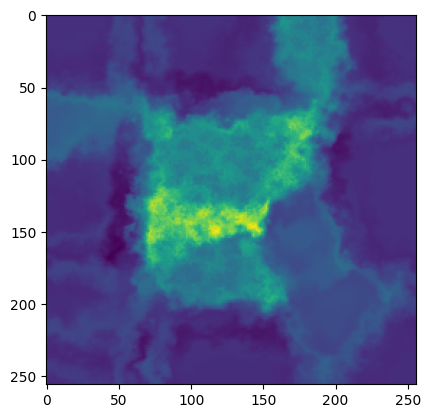

In [9]:
working_folder = REPO_ROOT / "params" / "working"
# save the edited params as yamls in the working directory
to_yaml(edited_world_params, working_folder / "world_params.yaml")
to_yaml(edited_imaging_params, working_folder / "imaging_params.yaml")

params = load_params(input_folder=working_folder, output_folder=output_folder)
base, mountains, Z, river_z, secondary = run(params=params, autosave=True)
params.root_params.save()

Note that instead of plotting the image this time, it's being saved.  
Your automatically blended Z image can be found at output/date_and_time.  
The image name contains the maximum and minimum height values, as the image itself has been normalized to better use the available bit depth.  
Additionally, the parameters that created this image are saved in the same folder.  

If you will want to reuse these parameters after you close this notebook, you can download them from params/working and save them locally.

# Step 4 Post Processing (optional)

If you want to manually blend the different components of the output (base, mountains, rivers), or see what they each look like, they're each available as a separate image.  
Because the blended Z values were normalized already, only these are of a different format.

To begin, it's best to check the value ranges present in each image.

In [10]:
print(f"Base height is of type {type(base)} and ranges from {base.min():.5f} to {base.max():.5f}")
print(f"Mountains is of type {type(mountains)} and ranges from {mountains.min():.5f} to {mountains.max():.5f}")
print(f"River_z is of type {type(river_z)} and ranges from {river_z.min():.5f} to {river_z.max():.5f}")
print(f"Secondary is of type {type(secondary)} and ranges from {secondary.min():.5f} to {secondary.max():.5f}")
print(f"Z is of type {type(Z)} and ranges from {Z.min():.5f} to {Z.max():.5f}")

Base height is of type <class 'numpy.ndarray'> and ranges from -2.54501 to 2.06892
Mountains is of type <class 'numpy.ndarray'> and ranges from 0.00000 to 1.46504
River_z is of type <class 'numpy.ndarray'> and ranges from 0.00000 to 0.00000
Secondary is of type <class 'numpy.ndarray'> and ranges from -1.21597 to 1.78243
Z is of type <class 'numpy.ndarray'> and ranges from 0.00000 to 65535.00000


To view one of these layers individually, we can use the plt.imshow() function.  
If you're using the gpu, then this will require the need to be converted. The to_numpy function will convert either type of array to a numpy array.

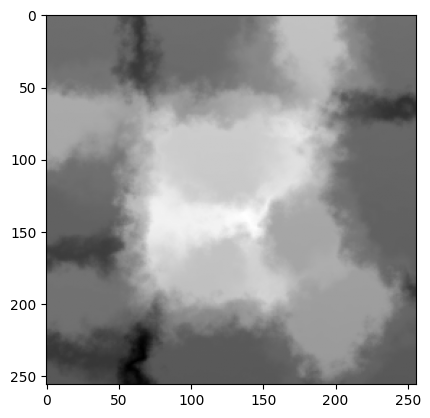

In [11]:
plt.imshow(to_numpy(base), cmap='grey')
plt.show()

One particularly useful change is to reduce the range on areas of the map below sea level.  
To do this we can use the flatten_negative() function, in which all values below a certain threshold are scaled down towards the threshold.  

Because the river texture should not be present below sea level, and should give dramatic mountains at high altitudes, we can first flatten the base height and then multiply this by the river height to give a corrected river texture.

In [12]:
base_0 = flatten_negative(base, threshold=0.0, weight = 0.9)
river_0 = np.multiply(river_z, base_0)

In [13]:
custom_blend = (base * 0.2
                + mountains * 0.9
                + river_z * 0.1
                + base_0 * 0.8
                + river_0 * 0.7
)

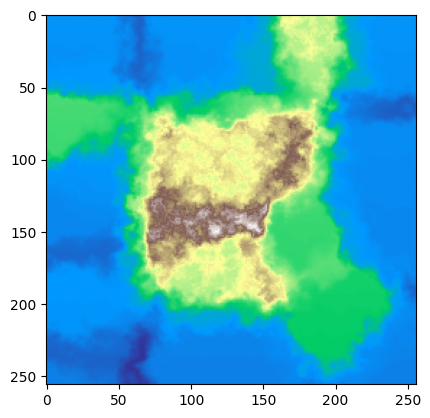

In [14]:
plt.imshow(to_numpy(custom_blend), cmap='terrain')
plt.show()

To save this blended image, we can run normalize().  
This will save the image as a greyscale (with no scalebars, just the heightmap) as a uint8 image to be used in other programs.  

To best use the available image depth, this image is rescaled, with the original min and max values included in the file name.

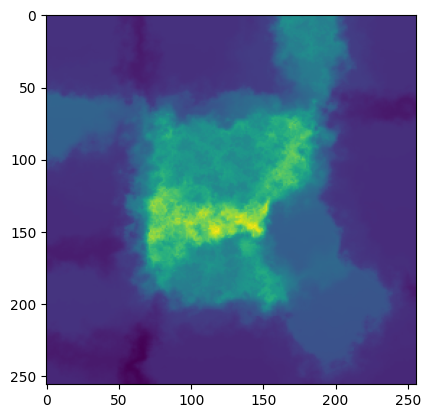

In [15]:
blended_normalized = normalize(custom_blend, params.root_params.timestamped_output_folder)

# Interactive generator (EXPERIMENTAL)

In order to quickly iterate through world layouts, use the interactive version of this notebook by running the cell below.

If performance is slow, consider setting river scale to 0 while determining layout of tectonic plates.  
This is especially recommended when not using GPU runtimes.

In [ ]:

# --- Define sliders for key world parameters ---
world_size_slider = widgets.FloatSlider(value=params.root_params.world.world_size, min=100, max=1000, step=1, description='World Size')
mountain_heights_slider = widgets.FloatSlider(value=params.root_params.world.mountain_heights, min=0, max=1, step=0.01, description='Mountains')
river_scale_slider = widgets.FloatSlider(value=params.root_params.world.river_scale, min=0, max=1000, step=10.0, description='River Scale')
river_density_slider = widgets.IntSlider(value=params.root_params.world.river_density, min=5, max=30, step=1, description='River Density')

global_section = widgets.VBox([world_size_slider, mountain_heights_slider, river_scale_slider, river_density_slider])
# Assume centroids and heights are loaded from params
# --- Mutable lists for plates ---
centroids = list(params.root_params.world.centroids)
heights = list(params.root_params.world.heights_tectonic_plates)
slopes_x = list(params.root_params.world.slopes_x)
slopes_y = list(params.root_params.world.slopes_y)


auto_update_toggle = widgets.ToggleButton(value=False, description='Auto-update', button_style='info')
recalc_button = widgets.Button(description='Recalculate', button_style='success')


def on_slider_change(change):
    if auto_update_toggle.value:
        update_world_image_params()
def set_widgets_disabled(widgets_list, value=True):
    for w in widgets_list:
        if isinstance(w, (list, tuple)):
            set_widgets_disabled(w, value)
        else:
            try:
                w.disabled = value
            except Exception:
                pass

def get_all_sliders_and_buttons():
    # Collect all widgets you want to disable/enable
    all_widgets = []
    # Add global and image sliders if they exist
    all_widgets.extend(global_and_image_sliders_list)
    for pair in centroid_sliders:
        all_widgets.extend(pair)
    all_widgets.extend(height_sliders)
    all_widgets.extend(slope_x_sliders)
    all_widgets.extend(slope_y_sliders)
    # all_widgets.extend(blend_sliders)
    # Add remove/add buttons
    for child in centroids_section.children:
        if isinstance(child, widgets.HBox):
            for item in child.children:
                if isinstance(item, widgets.Button):
                    all_widgets.append(item)
        elif isinstance(child, widgets.Button):
            all_widgets.append(child)
    # all_widgets.append(recalc_button)
    # all_widgets.append(auto_update_toggle)
    return all_widgets


def observe_all_sliders(initial_slider_list, centroid_list, heights_list, slopes_x_list, slopes_y_list, *args):

    # Add centroid and height sliders
    for (x_slider, y_slider) in centroid_list:
        initial_slider_list.extend([x_slider, y_slider])
    initial_slider_list.extend(heights_list)
    initial_slider_list.extend(slopes_x_list)
    initial_slider_list.extend(slopes_y_list)

    # Attach the observer to all sliders in one loop
    for slider in initial_slider_list:
        slider.observe(on_slider_change, names='value')

def sync_plate_lists_from_sliders():
    # Update the lists from the current slider values
    for i, (x_slider, y_slider) in enumerate(centroid_sliders):
        centroids[i][0] = x_slider.value
        centroids[i][1] = y_slider.value
    for i, z_slider in enumerate(height_sliders):
        heights[i] = z_slider.value
    for i, sx_slider in enumerate(slope_x_sliders):
        slopes_x[i] = sx_slider.value
    for i, sy_slider in enumerate(slope_y_sliders):
        slopes_y[i] = sy_slider.value

def rebuild_centroid_widgets(global_and_image_sliders_list, delta=0):
    # Sync lists from current slider values before modifying
    # set_widgets_disabled(get_all_sliders_and_buttons(), True)

    # old_centroids_values = centroid_sliders.copy()
    centroid_sliders.clear()
    height_sliders.clear()
    slope_x_sliders.clear()
    slope_y_sliders.clear()
    centroid_widgets = []
    for i, (centroid, height, sx, sy) in enumerate(zip(centroids, heights, slopes_x, slopes_y)):
        x_slider = widgets.FloatSlider(value=centroid[0], min=0, max=1, step=0.01, description=f'Plate {i+1} : X')
        y_slider = widgets.FloatSlider(value=centroid[1], min=0, max=1, step=0.01, description=f'Y')
        z_slider = widgets.FloatSlider(value=height, min=-1, max=1, step=0.01, description=f'Height')
        slope_x_slider = widgets.FloatSlider(value=sx, min=-1, max=1, step=0.01, description=f'Slope X')
        slope_y_slider = widgets.FloatSlider(value=sy, min=-1, max=1, step=0.01, description=f'Slope Y')
        remove_btn = widgets.Button(description="Remove", layout=widgets.Layout(width='80px'))
        def make_remove(idx):
            def remove_plate(_):
                set_widgets_disabled(get_all_sliders_and_buttons(), True)
                sync_plate_lists_from_sliders()
                centroids.pop(idx)
                heights.pop(idx)
                slopes_x.pop(idx)
                slopes_y.pop(idx)
                rebuild_centroid_widgets(global_and_image_sliders_list, delta=-1)
            return remove_plate
        remove_btn.on_click(make_remove(i))
        centroid_sliders.append((x_slider, y_slider))
        height_sliders.append(z_slider)
        slope_x_sliders.append(slope_x_slider)
        slope_y_sliders.append(slope_y_slider)
        centroid_widgets.append(widgets.HBox([x_slider, y_slider, z_slider, slope_x_slider, slope_y_slider, remove_btn]))
    # Add button to add a new plate
    add_btn = widgets.Button(description="Add Plate", button_style='success')
    def add_plate(_):
        set_widgets_disabled(get_all_sliders_and_buttons(), True)
        sync_plate_lists_from_sliders()
        centroids.append([0.0, 0.0])
        heights.append(0.0)
        slopes_x.append(0.0)
        slopes_y.append(0.0)
        rebuild_centroid_widgets(global_and_image_sliders_list, delta=1)
    add_btn.on_click(add_plate)
    centroids_section.children = centroid_widgets + [add_btn]
    observe_all_sliders(global_and_image_sliders_list, centroid_sliders, height_sliders, slope_x_sliders, slope_y_sliders)
    set_widgets_disabled(get_all_sliders_and_buttons(), False)

# Initial build
centroid_sliders = []
height_sliders = []
slope_x_sliders = []
slope_y_sliders = []
centroids_section = widgets.VBox()

offset_x_slider = widgets.FloatSlider(value=params.root_params.imaging.offset_x/params.root_params.world.world_size, min=-1, max=1, step=0.01, description='Offset X (proportional)')
offset_y_slider = widgets.FloatSlider(value=params.root_params.imaging.offset_y/params.root_params.world.world_size, min=-1, max=1, step=0.01, description='Offset Y (proportional)')
zoom_slider = widgets.FloatSlider(value=params.root_params.imaging.zoom, min=0.5, max=50.0, step=0.1, description='Zoom')
resolution_slider = widgets.SelectionSlider(
    options=[2**i for i in range(6, 13)],  # 64 to 4096
    value=params.root_params.imaging.resolution,
    description='Resolution'
)
tiling_slider = widgets.IntSlider(value=params.root_params.imaging.tiling, min=1, max=64, step=1, description='Tiling')

image_params_section = widgets.VBox([offset_x_slider, offset_y_slider, zoom_slider, resolution_slider, tiling_slider])
global_and_image_sliders_list = [
    world_size_slider,
    mountain_heights_slider,
    river_scale_slider,
    river_density_slider,
    offset_x_slider,
    offset_y_slider,
    zoom_slider,
    resolution_slider,
    tiling_slider,
]

rebuild_centroid_widgets(global_and_image_sliders_list)



def update_auto_update_button(*args):
    if auto_update_toggle.value:
        auto_update_toggle.description = "Auto-update: ON"
        auto_update_toggle.button_style = "success"
    else:
        auto_update_toggle.description = "Auto-update: OFF"
        auto_update_toggle.button_style = "info"

# Attach this function to the toggle button
auto_update_toggle.observe(update_auto_update_button, names='value')

# Call once to set initial state
update_auto_update_button()

save_button = widgets.Button(description="Save current output", button_style='success')

def save_blend_callback(_):
    new_folder_timestamp = datetime.now()
    new_folder = output_folder / new_folder_timestamp.strftime("%Y-%m-%d_%H-%M-%S")
    params = load_params(input_folder=working_folder, output_folder=output_folder)
    blend = create_blended_image()
    _ = normalize(blend, new_folder)

    to_yaml(params.root_params.world, new_folder / "world_params.yaml")
    # params.root_params.save() # NB: This currently overwrites the params and stores everything for a session in one output folder. Changing this (if desired) will require editing how the RootParams class defines its timestamp
save_button.on_click(save_blend_callback)

recalc_section = widgets.HBox([auto_update_toggle, recalc_button, save_button])


blend_layers = {}
# --- Function to update params and plot ---
def update_world_image_params(*args):
    edited_world_params = {
        "world_size": world_size_slider.value,
        "mountain_heights": mountain_heights_slider.value,
        "river_scale": river_scale_slider.value,
        # Add other parameters as needed...
        "centroids": [[x.value, y.value] for x, y in centroid_sliders],  # Or provide a way to edit
        "heights_tectonic_plates": [z.value for z in height_sliders],
        "slopes_x": [sx.value for sx in slope_x_sliders],
        "slopes_y": [sy.value for sy in slope_y_sliders],
        "river_density": river_density_slider.value,
    }
    edited_imaging_params = {
        "offset_x": offset_x_slider.value*world_size_slider.value,
        "offset_y": offset_y_slider.value*world_size_slider.value,
        "zoom": zoom_slider.value,
        "resolution": resolution_slider.value,
        "tiling": tiling_slider.value,
    }
    # Convert dict to WorldParams and save
    world_params_obj = map_generator.parameters.WorldParams.from_dict(edited_world_params)
    to_yaml(world_params_obj, working_folder / "world_params.yaml")
    img_params_obj = map_generator.parameters.ImagingParams.from_dict(edited_imaging_params)
    to_yaml(img_params_obj, working_folder / "imaging_params.yaml")
    # Reload params and run
    params = load_params(input_folder=working_folder, output_folder=output_folder)
    base, mountains, Z, river_z, secondary = run(params=params, autosave=False)
    # Precompute blend layers
    base_0 = flatten_negative(base, threshold=0.0, weight=0.9)
    river_0 = np.multiply(river_z, base_0)
    base_np = to_numpy(base)
    mountains_np = to_numpy(mountains)
    river_z_np = to_numpy(river_z)
    base_0_np = to_numpy(base_0)
    river_0_np = to_numpy(river_0)
    secondary_np = to_numpy(secondary)
    # Z is already a numpy array (normalized)
    Z_np = Z
    # Plot result# Store for blending
    blend_layers.clear()
    blend_layers.update({
        "base": base_np,
        "mountains": mountains_np,
        "river_z": river_z_np,
        "base_0": base_0_np,
        "river_0": river_0_np,
        "Z": Z_np,
        "secondary": secondary_np,
    })

    # Initial blend and plot
    update_blend_plot()


# --- Blend sliders (including Z) ---
blend_labels = ['base', 'mountains', 'river_z', 'base_0', 'river_0', 'Z', 'secondary']
blend_defaults = [0.2, 0.9, 0.1, 0.8, 0.7, 0.0, 0.0]
blend_sliders = [
    widgets.FloatSlider(value=val, min=0, max=1, step=0.01, description=label)
    for val, label in zip(blend_defaults, blend_labels)
]
blend_output = widgets.Output()

def create_blended_image():
    w = [slider.value for slider in blend_sliders]
    blend = (
        w[0]*blend_layers["base"] +
        w[1]*blend_layers["mountains"] +
        w[2]*blend_layers["river_z"] +
        w[3]*blend_layers["base_0"] +
        w[4]*blend_layers["river_0"] +
        w[5]*blend_layers["Z"]/10000 +
        w[6]*blend_layers["secondary"]
    )
    return blend

def update_blend_plot(*args):
    if not blend_layers:
        return
    blend = create_blended_image()
    with blend_output:
        clear_output(wait=True)
        fig = go.Figure(data=go.Heatmap(z=blend, colorscale='Earth_r'))
        fig.update_layout(
            width=750, height=750,
            margin=dict(l=0, r=0, t=30, b=0),
        )
        fig.show()
# --- Connect sliders to blend update ---
for slider in blend_sliders:
    slider.observe(update_blend_plot, names='value')

# --- Display controls and plot ---
blend_controls = widgets.VBox(blend_sliders)

accordion = widgets.Accordion(children=[global_section, centroids_section, image_params_section, blend_controls])
accordion.set_title(0, 'Global Parameters')
accordion.set_title(1, 'Plate Centroids & Heights')
accordion.set_title(2, 'Image Parameters')
accordion.set_title(3, 'Blend Controls')


def on_recalc_clicked(b):
    update_world_image_params()

# --- Set up output area and widget events ---
output = widgets.Output()
# Collect all sliders into a single flat list


observe_all_sliders(global_and_image_sliders_list, centroid_sliders, height_sliders, slope_x_sliders, slope_y_sliders)


display(widgets.HBox( children=[global_section, image_params_section, blend_controls]), centroids_section, blend_output, recalc_section)

# Initial plot
update_world_image_params()